# Finetuning Gemma-3N for Parkinson's Disease Audio Detection

This notebook will finetune Gemma-3N model to detect Parkinson's disease from audio data using the Unsloth library.

### Setup Instructions for Google Colab

1. Upload this notebook to Google Colab
2. Make sure to select GPU runtime:
   - Go to Runtime -> Change runtime type
   - Set "Hardware accelerator" to "GPU"
   - Click "Save"
3. Upload your data files to Colab:
   - Create a `/content/data` directory
   - Upload `combined_train.jsonl` and `combined_test.jsonl` to `/content/data`
   - The audio files should also be uploaded to their respective directories under `/content/data`

The notebook will use the Colab T4 GPU and install all necessary dependencies automatically.

In [1]:
import os
import torch

# Check if running in Colab
IN_COLAB = 'COLAB_GPU' in os.environ

# Verify GPU availability
if not torch.cuda.is_available():
    raise RuntimeError("No GPU found. Please make sure you enabled GPU in Colab: Runtime -> Change runtime type -> GPU")

# Print GPU info
print(f"Using GPU: {torch.cuda.get_device_name(0)}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using GPU: Tesla T4
GPU Memory: 15.83 GB


### Installation

In [3]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth

In [4]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps --upgrade transformers # Only for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

### Load Model

In [5]:
import torch
from unsloth import FastModel
import gc
import os

# Clear any existing cached memory
torch.cuda.empty_cache()
gc.collect()

# Set PyTorch memory allocator settings
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Load model with simpler memory optimization
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E2B-it",  # Using smaller 2B model
    dtype = torch.float16,  # Explicitly use torch.float16
    max_seq_length = 256,  # Reduced sequence length
    load_in_4bit = True,  # 4-bit quantization
    full_finetuning = False,
    device_map = "auto",  # Let the model handle memory management automatically
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.1: Fast Gemma3N patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/2.65G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/469M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

In [6]:
# Check GPU memory status
def print_gpu_memory():
    if torch.cuda.is_available():
        print("GPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")
        print(f"Free: {torch.cuda.get_device_properties(0).total_memory / 1e9 - torch.cuda.memory_allocated() / 1e9:.2f} GB")

print_gpu_memory()

GPU Memory Usage:
Allocated: 8.12 GB
Cached: 9.64 GB
Free: 7.71 GB


### Setup for Generation

In [7]:
from transformers import TextStreamer
import gc
import torch

def do_gemma_3n_inference(model, messages, max_new_tokens=128):
    try:
        # Don't wrap messages in an extra list - it's already a list
        inputs = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt"
        )

        # Move inputs to device after creation
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=1.0,
            top_p=0.95,
            top_k=64,
            streamer=TextStreamer(tokenizer, skip_prompt=True),
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

    except Exception as e:
        print(f"Error during generation: {str(e)}")
        if 'inputs' in locals():
            print(f"Input shape: {inputs['input_ids'].shape}")
            print(f"Input device: {inputs['input_ids'].device}")
    finally:
        # Cleanup
        if 'inputs' in locals():
            del inputs
        if 'outputs' in locals():
            del outputs
        torch.cuda.empty_cache()
        gc.collect()

### Add LoRA Adapters

In [8]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just audio/text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for audio analysis
    finetune_mlp_modules      = True,  # Should leave on always!

    r = 8,           # LoRA rank
    lora_alpha = 16, # Higher alpha can help with learning
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

Unsloth: Making `model.base_model.model.model.language_model` require gradients


### Data Preparation

In [9]:
import json
import pandas as pd
import os

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

# Set data directory based on environment
if 'COLAB_GPU' in os.environ:
    data_dir = '/content/drive/MyDrive/data'
else:
    data_dir = '../data'

# Load training and test data
train_data = load_jsonl(os.path.join(data_dir, 'combined_train.jsonl'))
test_data = load_jsonl(os.path.join(data_dir, 'combined_test.jsonl'))

# Convert to DataFrame for easier handling
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

print(f"Loaded {len(train_data)} training examples and {len(test_data)} test examples")

Loaded 9534 training examples and 2385 test examples


In [10]:
# Filter out examples with missing audio files
def filter_valid_examples(data, base_dir):
    valid_examples = []
    skipped = 0

    for item in data:
        is_valid = True
        for message in item['messages']:
            if message['role'] == 'user':
                for content in message['content']:
                    if content['type'] == 'audio':
                        audio_path = os.path.join(base_dir, content['audio'].replace('\\', os.sep))
                        if not os.path.exists(audio_path):
                            is_valid = False
                            skipped += 1
                            break
        if is_valid:
            valid_examples.append(item)

    print(f"Skipped {skipped} examples with missing audio files")
    print(f"Retained {len(valid_examples)} valid examples")
    return valid_examples

# Filter training and test data
train_data = filter_valid_examples(train_data, data_dir)
test_data = filter_valid_examples(test_data, data_dir)

Skipped 0 examples with missing audio files
Retained 9534 valid examples
Skipped 0 examples with missing audio files
Retained 2385 valid examples


In [11]:
from unsloth.chat_templates import get_chat_template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

In [12]:
from datasets import Dataset

# Format conversations into the expected format
def format_conversations(examples):
    conversations = []
    # Handle batch of examples
    for messages in examples['messages']:
        conversations.append(messages)
    return {'conversations': conversations}

# Create dataset directly from the list of dictionaries
train_dataset = Dataset.from_list(train_data)

# Apply conversation formatting
train_dataset = train_dataset.map(
    format_conversations,
    batched=True,
    remove_columns=train_dataset.column_names  # Remove original columns after mapping
)

# Convert conversations to proper format for training
def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize=False, add_generation_prompt=False).removeprefix('<bos>') for convo in convos]
    return {"text": texts}

train_dataset = train_dataset.map(formatting_prompts_func, batched=True)

# Print sample to verify format
print("\nExample conversation format:")
print(train_dataset[0])

Map:   0%|          | 0/9534 [00:00<?, ? examples/s]

Map:   0%|          | 0/9534 [00:00<?, ? examples/s]


Example conversation format:
{'conversations': [{'content': [{'audio': None, 'text': "You are an assistant that detects Parkinson's disease from audio.", 'type': 'text'}], 'role': 'system'}, {'content': [{'audio': 'processed_italian_dataset\\audio_clips\\Control\\FB1VLIATFOO55M300320171243_clip9.wav', 'text': None, 'type': 'audio'}, {'audio': None, 'text': "Analyze this audio clip for signs of Parkinson's. Acoustic features: pitch=229.9Hz, zcr=0.114, centroid=1489.7Hz, jitter=0.000, shimmer=0.00dB, hnr=0.00.", 'type': 'text'}], 'role': 'user'}, {'content': [{'audio': None, 'text': "No significant signs of Parkinson's detected. Speech patterns appear normal.", 'type': 'text'}], 'role': 'assistant'}], 'text': "<start_of_turn>user\nYou are an assistant that detects Parkinson's disease from audio.\n\nAnalyze this audio clip for signs of Parkinson's. Acoustic features: pitch=229.9Hz, zcr=0.114, centroid=1489.7Hz, jitter=0.000, shimmer=0.00dB, hnr=0.00.<end_of_turn>\n<start_of_turn>model\nN

In [13]:
# Shuffle the training dataset
import numpy as np

# Set random seed for reproducibility
np.random.seed(3407)

# Shuffle the training data
shuffle_idx = np.random.permutation(len(train_dataset))
train_dataset = train_dataset.select(shuffle_idx)

print(f"Training dataset shuffled, {len(train_dataset)} examples available")

Training dataset shuffled, 9534 examples available


### Train the Model

In [14]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback
from typing import Dict

class LossTrackingCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.current_step = 0

    def on_log(self, args, state, control, logs: Dict, **kwargs):
        if 'loss' in logs:
            self.training_loss.append(logs['loss'])
            self.current_step += 1

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.training_loss)
        plt.title('Training Loss Over Time')
        plt.xlabel('Step')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def get_average_loss(self):
        return sum(self.training_loss) / len(self.training_loss) if self.training_loss else 0

# Create loss tracking callback
loss_tracker = LossTrackingCallback()

In [15]:
from trl import SFTTrainer, SFTConfig

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = None,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 16,  # Effective batch size = 16
        warmup_steps = 5,
        max_steps = 400,  # Add this line to stop at 400 steps
        num_train_epochs = 1,
        learning_rate = 1e-4,
        logging_steps = 10,
        optim = "paged_adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/9534 [00:00<?, ? examples/s]

In [16]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=2):   0%|          | 0/9534 [00:00<?, ? examples/s]

In [17]:
# Train the model with loss tracking
trainer.add_callback(loss_tracker)
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 9,534 | Num Epochs = 1 | Total steps = 400
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 16
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 16 x 1) = 16
 "-____-"     Trainable parameters = 10,567,680 of 5,450,005,952 (0.19% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
10,12.849500
20,10.168800
30,0.470900
40,0.055200
50,0.048900
60,0.048400
70,0.046700
80,0.046000
90,0.043600
100,0.045900



Average training loss: 0.6282


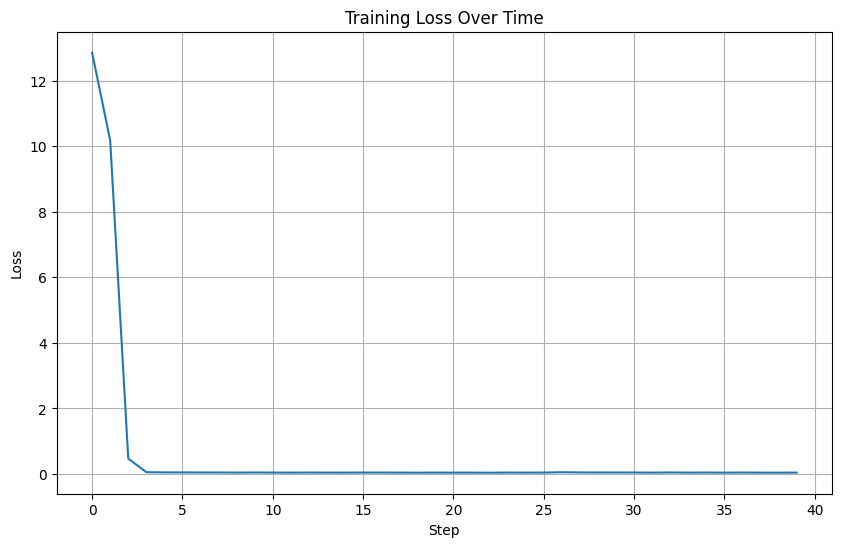

In [18]:
# Print and plot training statistics
print(f"\nAverage training loss: {loss_tracker.get_average_loss():.4f}")
loss_tracker.plot_loss()

### Save the Model

In [19]:
import os

# Set save path based on environment
if 'COLAB_GPU' in os.environ:
    save_path = "/content/drive/MyDrive/info/parkinsons_detector_gemma3n"
else:
    save_path = "parkinsons_detector_gemma3n"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the LoRA adapters and tokenizer
print(f"Saving model and tokenizer to {save_path}")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model and tokenizer saved successfully")

Saving model and tokenizer to /content/drive/MyDrive/info/parkinsons_detector_gemma3n
Model and tokenizer saved successfully
